In [1]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from geckoml.models import DenseNeuralNetwork
import matplotlib.pyplot as plt
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import glob
import re
import numpy as np
import argparse
import yaml


scalers = {"MinMaxScaler": MinMaxScaler,
           "MaxAbsScaler": MaxAbsScaler,
           "StandardScaler": StandardScaler,
           "RobustScaler": RobustScaler}

##################################

def get_data_serial(file_path, summary_file, bin_prefix, input_vars, output_vars, aggregate_bins):
    """
        Load an experiment file based on a summary file; combine data from summary into experiment file
    
    Args:
        file_path: Experiment file to load
        summary_file: Full path of the summary file 
        bin_prefix: Prefix of compound volitility bins if aggregation is used
        input_vars: List of varibles to subset for input
        ouput_vars: List of varibles to subset for ouput
        aggregate_bins: Boolean to aggregate bins
    
    Returns:
        input_subset: All input variable time series data for every experiment in pandas DataFrame
        output_subset: All ouput variable time series data for every experiment in pandas DataFrame
                       lagged by one time step
    """
    
    df = pd.read_csv(file_path)
    df.columns = [x.strip() for x in df.columns]
    exp_num = int(re.findall("_Exp(\d+).csv", file_path)[0])
    
    for variable in summary_file.columns:
        
        df[variable] = summary_file[summary_file['id'] == 
                                    'Exp{}'.format(exp_num)][variable][exp_num]
    if aggregate_bins: 
        
        for prefix in bin_prefix:

            df[prefix] = df.loc[:, df.columns.str.contains(prefix, regex=False)].sum(axis=1)
            
    input_subset, output_subset = df[input_vars].iloc[:-1,:], df[output_vars].iloc[1:,:]
    
    return input_subset, output_subset


def combine_data(dir_path, summary_file, aggregate_bins, bin_prefix,
                 input_vars, output_vars, min_exp, max_exp):
    """
        Distribute get_serial_data() using dask to parallelize tasks and concatenate dataframes 
    
    Args:
        summary_path: Full path of summary file
        min_exp: Minimum experiment number to process
        max_exp: Maximum experiment number to process
    
    Returns:
        input_subset: Complete pandas input dataframe 
        output_subset: Complete pandas output dataframe (lagged by one time step)
    """
    summary = pd.read_csv(dir_path+summary_file, skiprows=3)
    summary.columns = [x.strip() for x in summary.columns]
    
    dfs_in = [delayed(get_data_serial)
              (f, summary, bin_prefix=bin_prefix, input_vars=input_vars, output_vars=output_vars,
               aggregate_bins=aggregate_bins)[0] for f in sorted_filelist[min_exp:max_exp + 1]] 
    dfs_out = [delayed(get_data_serial)
               (f, summary, bin_prefix=bin_prefix, input_vars=input_vars, output_vars=output_vars,
                aggregate_bins=aggregate_bins)[1] for f in sorted_filelist[min_exp:max_exp + 1]] 

    ddf_in, ddf_out = dd.from_delayed(dfs_in), dd.from_delayed(dfs_out)  # assemble dask dfs
    
    df_in = ddf_in.compute(scheduler='processes').reset_index() # transform back to pandas df
    df_out = ddf_out.compute(scheduler='processes').reset_index() 

    del df_in['index'], df_out['index']
        
    return df_in, df_out

def split_data(input_data, output_data, n_splits=2, random_state=8):
    """
        Split data, by experiment, into training/validation/testing sets for both input/output dataframes
    
    Args:
        input_data: Complete input dataframe to process
        output_data: Complete output dataframe to process
        n_splits: Number of re-shuffling & splitting iterations
    
    Returns:
        in_train: training data input as pandas df (80% total input)
        in_val: validation data input as pandas df (10% total input)
        in_test: testing data input as pandas df (10% total input)
        out_train: training data output as pandas df (80% total output)
        out_val: validation data output as pandas df (10% total output)
        out_test: testing data output as pandas df (10% total output)
    """
    train_indx, remain_indx = next(GroupShuffleSplit(test_size=.2, n_splits=n_splits,
                                    random_state=random_state).split(input_data, groups=input_data['id']))
    
    in_train, out_train = input_data.iloc[train_indx], output_data.iloc[train_indx]
    remain_in, remain_out = input_data.iloc[remain_indx], output_data.iloc[remain_indx]
    
    val_indx, test_indx = next(GroupShuffleSplit(test_size=.5, n_splits=n_splits,
                                    random_state=random_state).split(remain_in, groups=remain_in['id']))
     
    in_val, out_val = remain_in.iloc[val_indx], remain_out.iloc[val_indx]
    in_test, out_test = remain_in.iloc[test_indx], remain_out.iloc[test_indx]

    return in_train, out_train, in_val, out_val, in_test, out_test

def repopulate_scaler(scale_data, scaler_type="StandardScaler"):
    """
    Given a csv file containing scaling values, repopulate a scikit-learn
    scaling object with those same values.
    Args:
        scale_file (str): path to csv file containing scale values
        scaler_type (str):
    Returns:
        scaler_obj: Scaler Object with normalizing values specified.
    """
    scaler_obj = scalers[scaler_type]()
    for column in scale_data.columns[1:]:
        setattr(scaler_obj, column + "_", scale_data[column].values)
    return scaler_obj

In [3]:
%%time

parser = argparse.ArgumentParser()
#parser.add_argument("config", required=True, help="Path to config file")
#args = parser.parse_args()


with open('/glade/u/home/cbecker/gecko-ml/cbecker/agg_config.yml') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

# Extract config arguments and validate if necessary

dir_path = config['dir_path']
summary_file = config['summary_file']
aggregate_bins = config['aggregate_bins']
bin_prefix = config['bin_prefix']
min_exp = config['min_exp']
max_exp = config['max_exp']
input_vars = config['input_vars']
output_vars = config['output_vars']

file_list = glob.glob(dir_path+'ML2019_dodecane_ML2019_Exp*')
sorted_filelist = sorted(file_list, key=lambda x:list(map(int, re.findall("_Exp(\d+).csv", x))))


# Load GECKO experiment data, split into ML inputs and outputs and persistence outputs
input_data, output_data = combine_data(dir_path, summary_file, aggregate_bins, bin_prefix,
                                       input_vars, output_vars, min_exp, max_exp)

# Split into training, validation, testing subsets
in_train, out_train, in_val, out_val, in_test, out_test = split_data(input_data, output_data)

# Rescale training and validation / testing data
scaled_in_train = repopulate_scaler(in_train).fit_transform(in_train.iloc[:,:-1])
scaled_in_val = repopulate_scaler(in_val).fit_transform(in_val.iloc[:,:-1])
scaled_out_train = repopulate_scaler(out_train).fit_transform(out_train.iloc[:,:-1])
scaled_out_val = repopulate_scaler(out_val).fit_transform(out_val.iloc[:,:-1])

# Train ML models

# Calculate validation and testing scores

# Save ML models, scaling values, and verification data to disk

#if __name__ == "__main__":
#    main()

FileNotFoundError: [Errno 2] No such file or directory: '/glade/u/home/cbecker/gecko-ml/cbecker/agg_config.yml'

In [2]:
dn = DenseNeuralNetwork(hidden_layers=2, hidden_neurons=100,verbose=1,lr=0.0001,batch_size=512, epochs=5)
dn.fit(scaled_in_train,scaled_out_train)
preds = pd.DataFrame(dn.predict(scaled_in_val).reshape(-1,scaled_out_train.shape[1]))
#rescaled_preds = repopulate_scaler(preds).inverse_transform(preds)

NameError: name 'scaled_in_train' is not defined

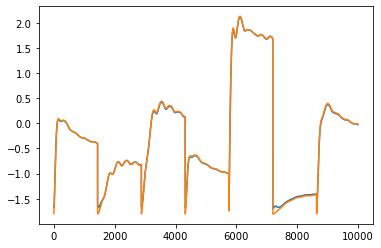

In [10]:
plt.plot(preds.iloc[:10000,2])
plt.plot(scaled_out_val[:10000,2])

In [6]:
preds

NameError: name 'preds' is not defined